# Semantic smart chunking with Azure Document Intelligence

Semantic Chunking considers the relationships within the text. It divides the text into meaningful, semantically complete chunks. This approach ensures the information’s integrity during retrieval, leading to a more accurate and contextually appropriate outcome. 
 
## Note
Document Intelligence public preview releases provide early access to features that are in active development. Features, approaches, and processes may change, prior to General Availability (GA), based on user feedback.<br>
The public preview version of Document Intelligence client libraries default to REST API version 2024-07-31-preview.
Public preview version 2024-07-31-preview is currently only available in the following Azure regions. Note that the custom generative (document field extraction) model in AI Studio is only available in North Central US region:
- East US
- West US2
- West Europe
- North Central US

## Documentation

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-layout?view=doc-intel-4.0.0&tabs=sample-code


In [1]:
import matplotlib.pyplot as plt
import openai
import os
import pytz
import requests
import sys
import time

from dotenv import load_dotenv
from datetime import datetime
from IPython.display import Image
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from openai import AzureOpenAI

In [2]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.43.0


In [3]:
# Local timezone datetime
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
now = datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S")
print(f"Local time in {local_tz}: {now}")

Local time in Europe/Amsterdam: 06-Sep-2024 10:29:52


## 1. Settings

In [4]:
load_dotenv("azure.env")

# Azure Document Intelligence
AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
AZURE_DOCUMENT_INTELLIGENCE_KEY: str = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")

# Azure OpenAI
AZURE_OPENAI_API_ENDPOINT:str = os.getenv("AZURE_OPENAI_API_ENDPOINT")
AZURE_OPENAI_API_KEY:str = os.getenv("AZURE_OPENAI_API_KEY")

AZURE_API_VERSION: str = "2024-06-01"
MODEL: str = "gpt-4o-2024-08-06"

## 2.  Semantic chunking - Exemple 1

In [5]:
DOCS_DIR = "documents"

os.makedirs(DOCS_DIR, exist_ok=True)

In [6]:
document_file = os.path.join(DOCS_DIR, "contoso.pdf")

!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/contoso.pdf -O $document_file

--2024-09-06 08:29:52--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/contoso.pdf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/contoso.pdf [following]
--2024-09-06 08:29:52--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/contoso.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 544811 (532K) [application/octet-stream]
Saving to: ‘documents/contoso.pdf’

documents/contoso.p 100%[===================>] 532.04K  --.-KB/s    in 0.005s  

2024-09-06 08:29:52 (110 MB/s) - ‘documents/contoso.pdf’ save

In [7]:
!ls $document_file -lh

-rwxrwxrwx 1 root root 533K Sep  6 08:29 documents/contoso.pdf


In [8]:
start = time.time()

loader = AzureAIDocumentIntelligenceLoader(
    file_path=document_file,  # File to process
    api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY, # Key
    api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
    api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
    analysis_features=["ocrHighResolution"],  # To get OCR High resolution
)

# Loading the document
print("Processing the document with Azure Document Intelligence...")
documents = loader.load()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 8 seconds


### Extracted text

In [9]:
documents

[Document(page_content='Contoso Electronics Plan and Benefit Packages\n\n<figure>\n\n![](figures/0)\n\n<!-- FigureContent="Contoso Electronics" -->\n\n</figure>\n\n\nThis document contains information generated using a language model (Azure OpenAI). The information contained in this document is only for demonstration purposes and does not reflect the opinions or beliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied, about the completeness, accuracy, reliability, suitability or availability with respect to the information contained in this document.\n\nAll rights reserved to Microsoft\n\n<!-- PageHeader="Welcome to Contoso Electronics! We are excited to offer our employees two comprehensive health insurance plans through Northwind Health." -->\n\n\n# Northwind Health Plus\n\nNorthwind Health Plus is a comprehensive plan that provides comprehensive coverage for medical, vision, and dental services. This plan also offers prescription drug c

###  Semantic chunking

**Markdown** is a structured and formatted markup language and a popular input for enabling semantic chunking in RAG (Retrieval-Augmented Generation). You can use the Markdown content from the Layout model to split documents based on paragraph boundaries, create specific chunks for tables, and fine-tune your chunking strategy to improve the quality of the generated responses.

This method divides the text into chunks based on **semantic understanding**. Division boundaries are focused on sentence subject and use significant computational algorithmically complex resources. However, it has the distinct advantage of maintaining semantic consistency within each chunk. It's useful for text summarization, sentiment analysis, and document classification tasks.

https://learn.microsoft.com/en-us/azure/ai-services/document-intelligence/concept-retrieval-augmented-generation?view=doc-intel-4.0.0#semantic-chunking

In [10]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
]

headers_to_split_on

[('#', 'Header 1'),
 ('##', 'Header 2'),
 ('###', 'Header 3'),
 ('####', 'Header 4'),
 ('#####', 'Header 5')]

In [11]:
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
docs_string = documents[0].page_content
chunks = text_splitter.split_text(docs_string)

print(f"Number of chunks = {len(chunks)}")

Number of chunks = 6


In [12]:
chunk_size_list = []

for idx, chunk in enumerate(chunks, start=1):
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk.page_content)}\n")
    print(f"\033[1;34m{chunk.page_content}\033[0m\n")
    chunk_size_list.append(len(chunk.page_content))

***** Chunk 1 *****
Length of chunk = 768

Contoso Electronics Plan and Benefit Packages  
<figure>  
![](figures/0)  
<!-- FigureContent="Contoso Electronics" -->  
</figure>  
This document contains information generated using a language model (Azure OpenAI). The information contained in this document is only for demonstration purposes and does not reflect the opinions or beliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied, about the completeness, accuracy, reliability, suitability or availability with respect to the information contained in this document.  
All rights reserved to Microsoft  
<!-- PageHeader="Welcome to Contoso Electronics! We are excited to offer our employees two comprehensive health insurance plans through Northwind Health." -->

***** Chunk 2 *****
Length of chunk = 510

Northwind Health Plus is a comprehensive plan that provides comprehensive coverage for medical, vision, and dental services. This plan also offe

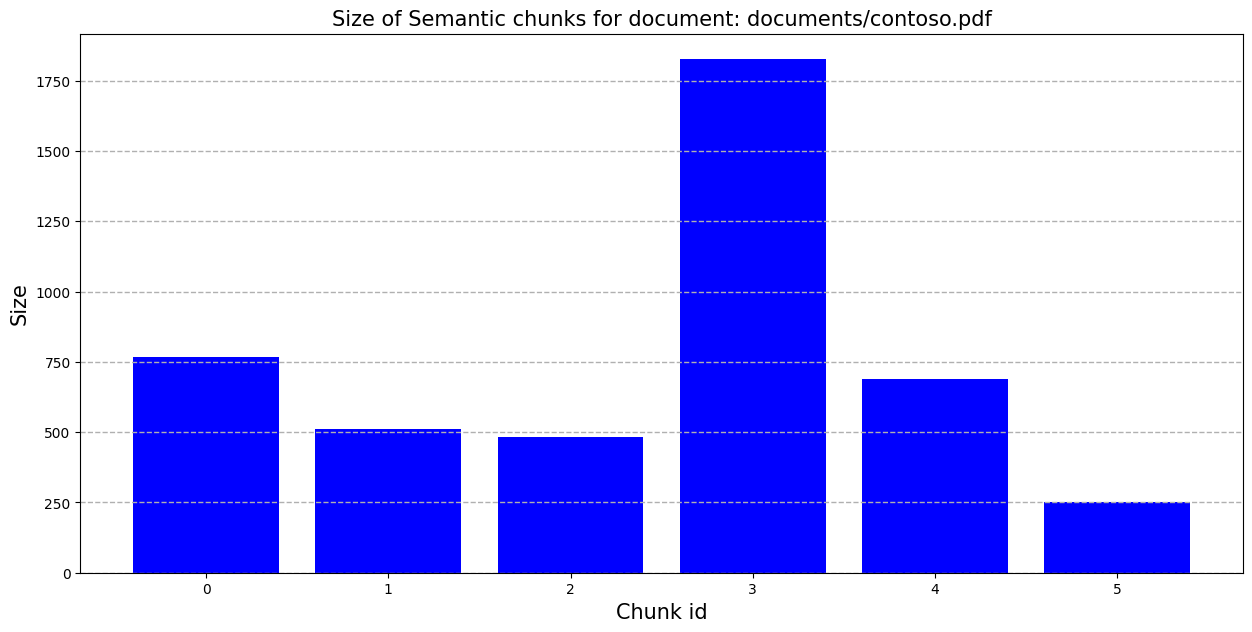

In [13]:
x = range(len(chunk_size_list))
bar_color = 'blue'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id', size=15)
plt.ylabel('Size', size=15)
plt.title(f'Size of Semantic chunks for document: {document_file}', size=15)
plt.xticks(x)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=1)

plt.show()

### Let's try to define each chunk with Azure OpenAI GPT-4o mini

In [14]:
def gpt_4omini(text):
    """
    Gpt-4o mini model
    """
    client = AzureOpenAI(
        api_key=AZURE_OPENAI_API_KEY,
        api_version=AZURE_API_VERSION,
        base_url=f"{AZURE_OPENAI_API_ENDPOINT}/openai/deployments/{MODEL}",
    )
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "system", "content": "You are an AI helpful assistant. Generate a summary of one line of this text like it was a header of a document."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": text},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.5,
    )

    return response

In [15]:
for idx, chunk in enumerate(chunks, start=1):
    chunk_text = chunk.page_content
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk_text)}\n")
    print(f"\033[1;34m{chunk_text}\033[0m\n")
    answer = gpt_4omini(chunk_text)
    print("\033[1;32m", end="")
    print(f"Chunk summary: {answer.choices[0].message.content}")
    print("\033[0m")

***** Chunk 1 *****
Length of chunk = 768

Contoso Electronics Plan and Benefit Packages  
<figure>  
![](figures/0)  
<!-- FigureContent="Contoso Electronics" -->  
</figure>  
This document contains information generated using a language model (Azure OpenAI). The information contained in this document is only for demonstration purposes and does not reflect the opinions or beliefs of Microsoft. Microsoft makes no representations or warranties of any kind, express or implied, about the completeness, accuracy, reliability, suitability or availability with respect to the information contained in this document.  
All rights reserved to Microsoft  
<!-- PageHeader="Welcome to Contoso Electronics! We are excited to offer our employees two comprehensive health insurance plans through Northwind Health." -->

Chunk summary: Welcome to Contoso Electronics: Explore Our Comprehensive Health Insurance Plans.

***** Chunk 2 *****
Length of chunk = 510

Northwind Health Plus is a comprehensive plan 

## 3. Semantic chunking - Exemple 2

In [16]:
document_file = os.path.join(DOCS_DIR, "resume.png")

!wget https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/resume.png -O $document_file

--2024-09-06 08:30:03--  https://github.com/retkowsky/Azure-OpenAI-demos/raw/main/documents/resume.png
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/resume.png [following]
--2024-09-06 08:30:03--  https://raw.githubusercontent.com/retkowsky/Azure-OpenAI-demos/main/documents/resume.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112343 (110K) [image/png]
Saving to: ‘documents/resume.png’

documents/resume.pn 100%[===================>] 109.71K  --.-KB/s    in 0.001s  

2024-09-06 08:30:03 (77.0 MB/s) - ‘documents/resume.png’ saved [112343/112343]



In [17]:
!ls $document_file -lh

-rwxrwxrwx 1 root root 110K Sep  6 08:30 documents/resume.png


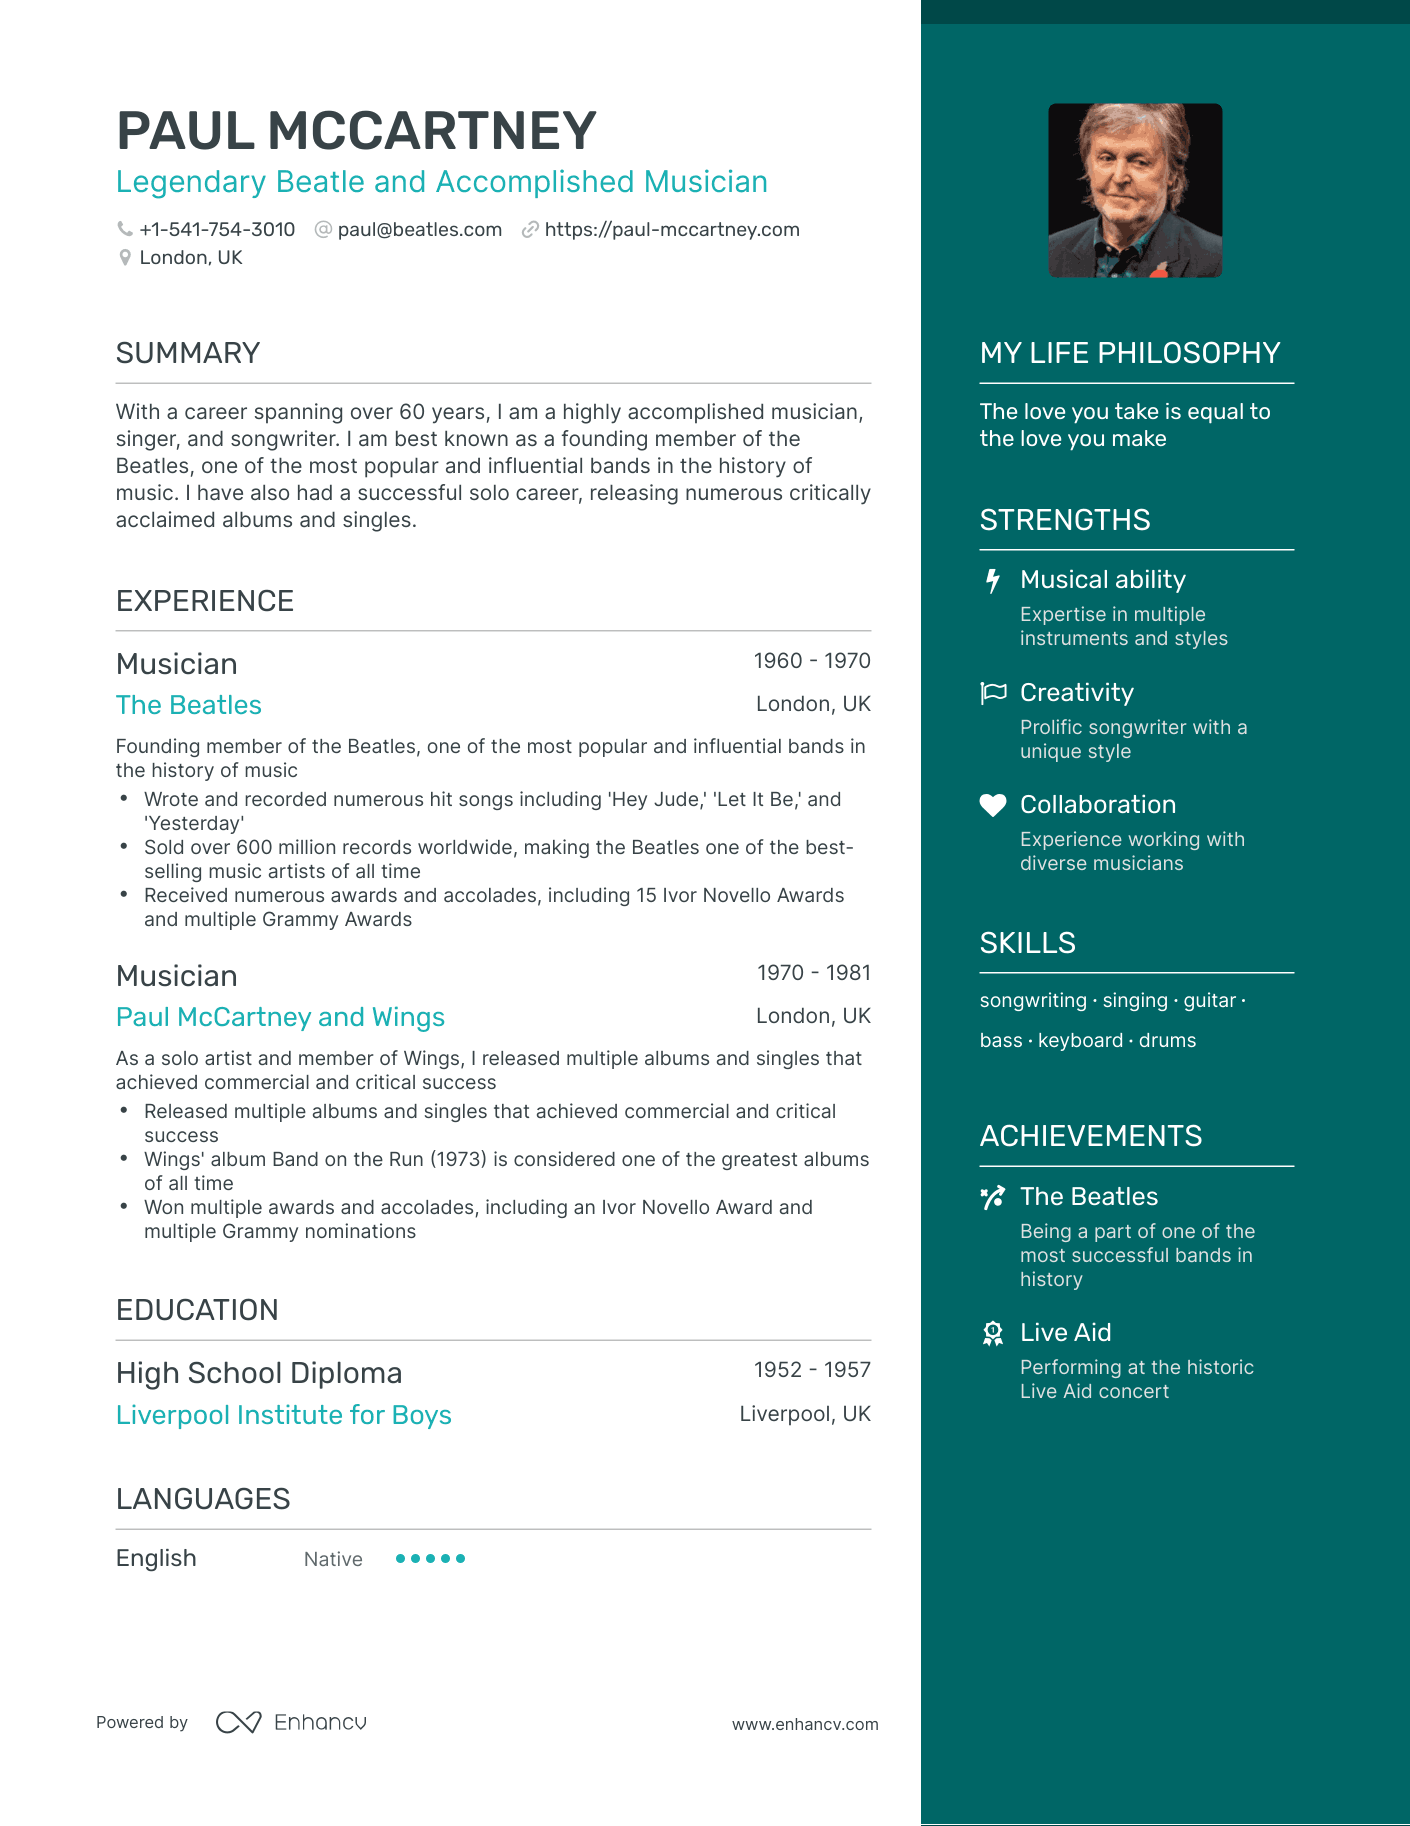

In [18]:
Image(filename=document_file) 

In [19]:
start = time.time()

loader = AzureAIDocumentIntelligenceLoader(
    file_path=document_file,  # File to process
    api_key=AZURE_DOCUMENT_INTELLIGENCE_KEY, # Key
    api_endpoint=AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT,  # Endpoint
    api_model="prebuilt-layout",  # Prebuilt layout of Azure Doc Intelligence
    analysis_features=["ocrHighResolution"],  # To get OCR High resolution
)

# Loading the document
print("Processing the document with Azure Document Intelligence...")
documents = loader.load()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print("\nDone")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing the document with Azure Document Intelligence...

Done
Elapsed time = 0 minutes and 5 seconds


In [20]:
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
]

text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
docs_string = documents[0].page_content
chunks = text_splitter.split_text(docs_string)

print(f"Number of chunks = {len(chunks)}")

Number of chunks = 8


In [21]:
chunk_size_list = []
chunk_summary = []

for idx, chunk in enumerate(chunks, start=1):
    chunk_text = chunk.page_content
    print(f"***** Chunk {idx} *****\nLength of chunk = {len(chunk_text)}\n")
    print(f"\033[1;34m{chunk_text}\033[0m\n")
    answer = gpt_4omini(chunk_text)
    chunk_summary.append(answer.choices[0].message.content)
    print("\033[1;32m", end="")
    print(f"Chunk summary: {answer.choices[0].message.content}")
    chunk_size_list.append(len(chunk.page_content))
    print("\033[0m")

***** Chunk 1 *****
Length of chunk = 147

PAUL MCCARTNEY
===  
Legendary Beatle and Accomplished Musician
===  
\+1-541-754-3010 @ paul@beatles.com https://paul-mccartney.com  
9 London, UK

Chunk summary: Legendary Beatle and Accomplished Musician: Paul McCartney

***** Chunk 2 *****
Length of chunk = 324

With a career spanning over 60 years, I am a highly accomplished musician, singer, and songwriter. I am best known as a founding member of the Beatles, one of the most popular and influential bands in the history of music. I have also had a successful solo career, releasing numerous critically acclaimed albums and singles.

Chunk summary: Legendary Musician and Beatles Co-Founder with a Celebrated Solo Career

***** Chunk 3 *****
Length of chunk = 912

1960 - 1970  
The Beatles London, UK  
Founding member of the Beatles, one of the most popular and influential bands in the history of music  
· Wrote and recorded numerous hit songs including 'Hey Jude,' 'Let It Be,' and 'Yesterday'

In [22]:
for idx, summary in enumerate(chunk_summary, start=1):
    print(f"Chunk {idx} summary: {summary}")

Chunk 1 summary: Legendary Beatle and Accomplished Musician: Paul McCartney
Chunk 2 summary: Legendary Musician and Beatles Co-Founder with a Celebrated Solo Career
Chunk 3 summary: The Beatles and Paul McCartney: Iconic Success from 1960 to 1981
Chunk 4 summary: High School Diploma (1952-1957) - Liverpool Institute for Boys, UK
Chunk 5 summary: The Balance of Love: What You Give is What You Receive
Chunk 6 summary: Versatile Musician: Multi-Instrumentalist, Creative Songwriter, and Collaborative Artist
Chunk 7 summary: Comprehensive Guide to Music Skills: Songwriting, Singing, and Instruments
Chunk 8 summary: Performing at the Historic Live Aid Concert


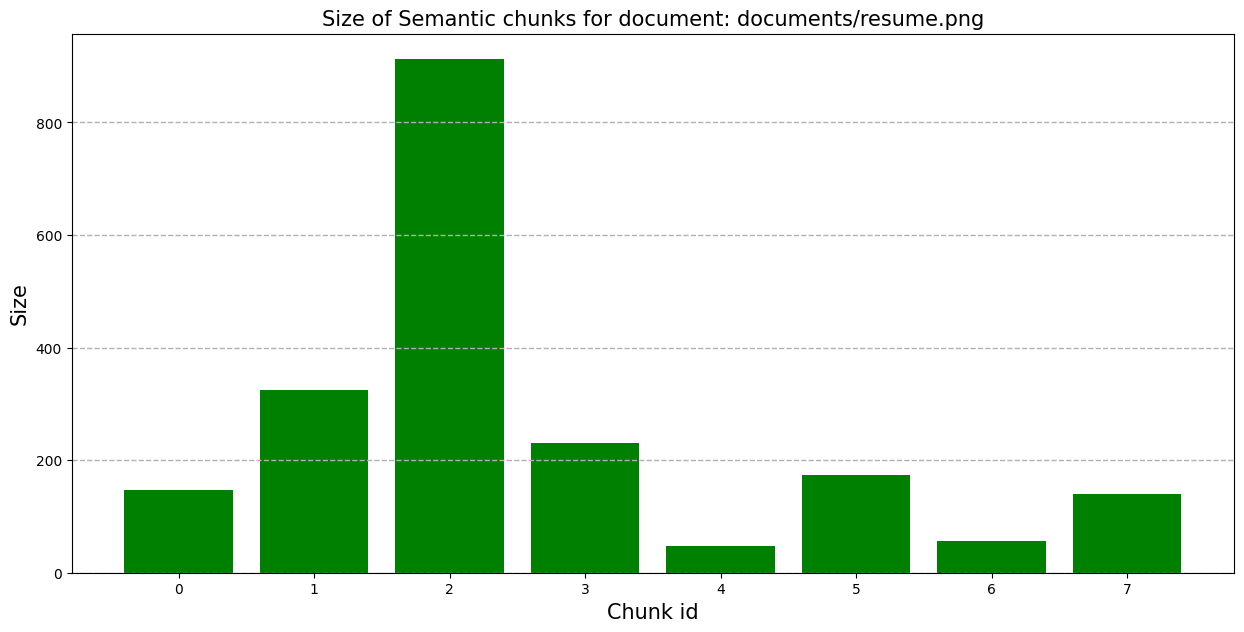

In [23]:
x = range(len(chunk_size_list))
bar_color = 'green'

plt.figure(figsize=(15, 7))
plt.bar(x, chunk_size_list, color=bar_color)
plt.xlabel('Chunk id', size=15)
plt.ylabel('Size', size=15)
plt.title(f'Size of Semantic chunks for document: {document_file}', size=15)
plt.xticks(x)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=1)

plt.show()